In [505]:
%matplotlib inline
import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from matplotlib.pyplot import *
import pandas as pd
import time
import pylab
import re
import sys
import statsmodels.api as sm
from numpy import arange,array,ones,linalg
from pylab import plot,show
from collections import defaultdict
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")
from pyquery import PyQuery as pq
from bs4 import BeautifulSoup
import requests
import statsmodels.api as sm
from statsmodels.formula.api import glm, ols
import json
import urllib
from configobj import ConfigObj
import sunlight

In [8]:
### controverisal bill topics
subject_keys = ['Budget, Spending, and Taxes', 'Education', 'Guns', 'Immigration', 'Labor and Employment', 
                'Reproductive Issues', 'Sexual Orientation and Gender Issues', 'Social Issues', "Welfare and Poverty"]

### 50 states
state_keys = ['al','ak','az','ar','ca','co','ct','de','fl','ga','hi','id','il','in','ia','ks','ky','la','me']

In [228]:
### THIS FUNCTION ALSO DETERMINES SPONSOR PARTY (ends up being unnecessary, use VoteGetter2)

### gets data from api
def VoteGetter(subject_keys, state_keys):
    categories = ["state", "bill_id", "year", "subject", "party", "yesvoteslower", "novoteslower", "yesvotesupper", "novotesupper"]
    
    ### establish empty lists
    st_list = []
    bid_list = []
    y_list = []
    sub_list = []
    p_list = []
    yvl = []
    nvl = []
    yvu = []
    nvu = []
    
    ### filters through all states
    for i in range(len(state_keys)):
        print state_keys[i]
        
        ### filters through all subjects
        for j in range(len(subject_keys)):
            print subject_keys[j]
            sys.stdout.flush()
            
            ### hails information from API given state and subject
            legis = sunlight.openstates.bills(state = state_keys[i], subject = subject_keys[j])
            for leg in legis:
                removed = False
                
                ### empty lists
                st_list2 = []
                bid_list2 = []
                y_list2 = []
                sub_list2 = []
                p_list2 = []
                
                yvl2 = []
                nvl2 = []
                yvu2 = []
                nvu2 = []
                yvl3 = []
                nvl3 = []
                yvu3 = []
                nvu3 = []
                
                ### appends state name for each bill
                state = leg['state']
                st_list2.append(state)
                
                ### appends bill_id for each bill
                bill_id = leg['id']
                print bill_id
                bid_list2.append(bill_id)
                
                ### given bill_id, gathers more specific information from API
                whee = sunlight.openstates.bill(bill_id = bill_id)
                
                ### appends year
                actiondates = whee['action_dates']
                lastdate = actiondates['last']
                if lastdate == None:
                    legis.remove(leg)
                    removed = True
                    continue
                year = lastdate[:4]
                y_list2.append(year)
                
                ### appends subject
                subject = whee['subjects']
                sub_list2.append(subject)
                sponsors = whee['sponsors']
                
                ### empty lists for party
                rep_list = []
                dem_list = []
                other_list = []
                
                ### sifts through sponsors, determines majority, names that sponsor party
                for sponsor in sponsors:
                    legid = sponsor['leg_id']
                    if legid == None:
                        continue
                    else:
                        try:
                            legislators = sunlight.openstates.legislator_detail(leg_id = legid)
                        except:
                            break
                        if legislators.get('party') == None:
                            continue
                        elif legislators['party'] == "Republican":
                            rep_list.append(legislators['party'])
                        elif legislators['party'] == "Democratic":
                            dem_list.append(legislators['party'])
                        else:
                            other_list.append(legislators['party'])
                if len(rep_list) == 0 and len(dem_list) == 0:
                    legis.remove(leg)
                    removed = True
                    continue
                if len(rep_list) > len(dem_list):
                    p_list2.append("Republican")
                elif len(dem_list) > len(rep_list):
                    p_list2.append("Democrat")
                else:
                    p_list2.append("Bipartisan")
                    
                ### determines vote counts
                votes = whee['votes']
                found = False
                for vote in votes:
                    
                    ### only looks for voting information of votes that are deemed passage
                    if vote['type'] == "passage":
                        found = True
                        if vote['chamber'] == 'lower':
                            if vote['yes_count'] == None and vote['no_count'] == None:
                                yvl2.append(None)
                                nvl2.append(None) 
                            else:
                                yvl2.append(vote['yes_count'])
                                nvl2.append(vote['no_count'])
                        elif vote['chamber'] == 'upper':
                            if vote['yes_count'] == None and vote['no_count'] == None:
                                yvu2.append(None)
                                nvu2.append(None) 
                            else:
                                yvu2.append(vote['yes_count'])
                                nvu2.append(vote['no_count'])
                
                ### if more than one vote, calculates average yes and no vote composition
                if len(yvl2) > 1:
                    avgyvl2 = (sum(yvl2)/len(yvl2))
                    yvl3.append(avgyvl2)
                else:
                    yvl3.append(yvl2)
                    
                if len(nvl2) > 1:
                    avgnvl2 = (sum(nvl2)/len(nvl2))
                    nvl3.append(avgnvl2)
                else:
                    nvl3.append(nvl2)
                    
                if len(yvu2) > 1:
                    avgyvu2 = (sum(yvu2)/len(yvu2))
                    yvu3.append(avgyvu2)
                else:
                    yvu3.append(yvu2)
                    
                if len(nvu2) > 1:
                    avgnvu2 = (sum(nvu2)/len(nvu2))
                    nvu3.append(avgnvu2)  
                else:
                    nvu3.append(nvu2)
                    
                if not found:
                    legis.remove(leg)
                    removed = True
                    continue
                
                if not removed:
                    st_list.extend(st_list2)
                    bid_list.extend(bid_list2)
                    y_list.extend(y_list2)
                    sub_list.extend(sub_list2)
                    p_list.extend(p_list2)
                    yvl.extend(yvl3)
                    nvl.extend(nvl3)
                    yvu.extend(yvu3)
                    nvu.extend(nvu3)
    
    ### creates list of generated values for each bill, creates dictionary
    tot_list = [st_list, bid_list, y_list, sub_list, p_list, yvl, nvl, yvu, nvu]
    bill_dict = dict(zip(categories, tot_list))
    return bill_dict

In [695]:
### gets data from api
def VoteGetter2(subject_keys, state_keys):
    categories = ["state", "bill_id", "year", "subject", "yesvoteslower", "novoteslower", "yesvotesupper", "novotesupper"]
    
    ### establish empty lists
    st_list = []
    bid_list = []
    y_list = []
    sub_list = []
    yvl = []
    nvl = []
    yvu = []
    nvu = []
    
    ### filters through all states
    for i in range(len(state_keys)):
        print state_keys[i]
        
        ### filters through all subjects
        for j in range(len(subject_keys)):
            print subject_keys[j]
            sys.stdout.flush()
            
            ### hails information from API given state and subject
            legis = sunlight.openstates.bills(state = state_keys[i], subject = subject_keys[j])
            for leg in legis:
                removed = False
                
                ### empty lists
                st_list2 = []
                bid_list2 = []
                y_list2 = []
                sub_list2 = []
                
                yvl2 = []
                nvl2 = []
                yvu2 = []
                nvu2 = []
                yvl3 = []
                nvl3 = []
                yvu3 = []
                nvu3 = []
                
                ### appends state name for each bill
                state = leg['state']
                st_list2.append(state)
                
                ### appends bill_id for each bill
                bill_id = leg['id']
                print bill_id
                bid_list2.append(bill_id)
                
                ### given bill_id, gathers more specific information from API
                whee = sunlight.openstates.bill(bill_id = bill_id)
                
                ### appends year
                actiondates = whee['action_dates']
                lastdate = actiondates['last']
                if lastdate == None:
                    legis.remove(leg)
                    removed = True
                    continue
                year = lastdate[:4]
                y_list2.append(year)
                
                ### appends subject
                subject = whee['subjects']
                sub_list2.append(subject)
                
                ### determines vote counts
                votes = whee['votes']
                found = False
                for vote in votes:
                    
                    ### only looks for voting information of votes that are deemed passage
                    if vote['type'] == "passage":
                        found = True
                        if vote['chamber'] == 'lower':
                            if vote['yes_count'] == None and vote['no_count'] == None:
                                yvl2.append(None)
                                nvl2.append(None) 
                            else:
                                yvl2.append(vote['yes_count'])
                                nvl2.append(vote['no_count'])
                        elif vote['chamber'] == 'upper':
                            if vote['yes_count'] == None and vote['no_count'] == None:
                                yvu2.append(None)
                                nvu2.append(None) 
                            else:
                                yvu2.append(vote['yes_count'])
                                nvu2.append(vote['no_count'])
                                
                ### if more than one vote, calculates average yes and no vote composition
                if len(yvl2) > 1:
                    avgyvl2 = (sum(yvl2)/len(yvl2))
                    yvl3.append(avgyvl2)
                else:
                    yvl3.append(yvl2)
                    
                if len(nvl2) > 1:
                    avgnvl2 = (sum(nvl2)/len(nvl2))
                    nvl3.append(avgnvl2)
                else:
                    nvl3.append(nvl2)
                    
                if len(yvu2) > 1:
                    avgyvu2 = (sum(yvu2)/len(yvu2))
                    yvu3.append(avgyvu2)
                else:
                    yvu3.append(yvu2)
                    
                if len(nvu2) > 1:
                    avgnvu2 = (sum(nvu2)/len(nvu2))
                    nvu3.append(avgnvu2)  
                else:
                    nvu3.append(nvu2)
                    
                if not found:
                    legis.remove(leg)
                    removed = True
                    continue
                
                if not removed:
                    st_list.extend(st_list2)
                    bid_list.extend(bid_list2)
                    y_list.extend(y_list2)
                    sub_list.extend(sub_list2)
                    yvl.extend(yvl3)
                    nvl.extend(nvl3)
                    yvu.extend(yvu3)
                    nvu.extend(nvu3)
                    
    ### creates list of generated values for each bill, creates dictionary   
    tot_list2 = [st_list, bid_list, y_list, sub_list, yvl, nvl, yvu, nvu]
    bill_dict2 = dict(zip(categories, tot_list2))
    return bill_dict2

In [ ]:
### Only wi, ca, sd, and la generate correct information

subject_keys = ['Budget, Spending, and Taxes', 'Education', 'Guns', 'Immigration', 'Labor and Employment', 
                'Reproductive Issues', 'Sexual Orientation and Gender Issues', 'Social Issues', "Welfare and Poverty"]

state_keys = ['wi','ca','sd','la']

In [702]:
votes_list_star2 = VoteGetter2(subject_keys, state_keys)

ct
Budget, Spending, and Taxes
CTB00012924
CTB00013244
CTB00012801
CTB00013477
CTB00013036
CTB00013487
CTB00013436
CTB00013471
CTB00013451
CTB00013475
CTB00012970
CTB00013409
CTB00012691
CTB00013194
CTB00013208
CTB00012946
CTB00013192
CTB00012311
CTB00012233
CTB00013234
CTB00012653
CTB00013098
CTB00012787
CTB00013435
CTB00012742
CTB00013428
CTB00013472
CTB00013446
CTB00013483
CTB00012671
CTB00013026
CTB00013214
CTB00013484
CTB00013150
CTB00012217
CTB00013337
CTB00013387
CTB00013329
CTB00013309
CTB00012948
CTB00012985
CTB00012587
CTB00013250
CTB00012226
CTB00012988
CTB00012816
CTB00012569
CTB00012880
CTB00012686
CTB00012856
CTB00013101
CTB00012664
CTB00012838
CTB00012981
CTB00012396
CTB00013476
CTB00012419
CTB00013020
CTB00012821
CTB00012515
CTB00012890
CTB00013441
CTB00013448
CTB00013418
CTB00013072
CTB00013051
CTB00013070
CTB00012351
CTB00012333
CTB00013069
CTB00013181
CTB00013063
CTB00013075
CTB00012225
CTB00013153
CTB00013048
CTB00012619
CTB00012575
CTB00012357
CTB00012571
CTB000122

In [701]:
### creates dataframe of scraped information
submaster = pd.DataFrame(votes_list_star2)
submaster

,bill_id,novoteslower,novotesupper,state,subject,year,yesvoteslower,yesvotesupper
0,WIB00002113,21,[14],wi,"[Legislative Affairs, Budget, Spending and Tax...",2012,36,[19]
1,WIB00002778,[0],0,wi,"[Commerce, Social Issues, Budget, Spending and...",2012,[94],20
2,WIB00002917,[],5,wi,"[Commerce, Budget, Spending and Taxes, Labor a...",2012,[],13
3,WIB00003298,[3],0,wi,"[Budget, Spending and Taxes, State Agencies, B...",2012,[90],19
4,WIB00003445,8,[],wi,"[Commerce, Municipal and County Issues, Budget...",2012,43,[]
5,WIB00002537,0,0,wi,"[Social Issues, Legal Issues, Legislative Affa...",2012,54,18
6,WIB00002007,[0],[],wi,"[Agriculture and Food, Budget, Spending and Ta...",2012,[14],[]
7,WIB00002049,[5],[],wi,"[Commerce, Government Reform, Municipal and Co...",2012,[9],[]
8,WIB00002107,[],[4],wi,"[Legislative Affairs, Budget, Spending and Tax...",2012,[],[12]
9,WIB00002143,[],[0],wi,"[Commerce, Budget, Spending and Taxes, Energy,...",2012,[],[7]


In [561]:
### DO NOT RUN

MASTER = pd.DataFrame(votes_list_star)
MASTER.to_csv('Master.csv')
MASTER.count

,bill_id,novoteslower,novotesupper,party,state,subject,year,yesvoteslower,yesvotesupper
0,WIB00003132,[41],2,Republican,wi,"[Trade, Agriculture and Food, Technology and C...",2012,[50],18
1,WIB00002778,[0],0,Republican,wi,"[Commerce, Social Issues, Budget, Spending and...",2012,[94],20
2,WIB00002917,[],5,Republican,wi,"[Commerce, Budget, Spending and Taxes, Labor a...",2012,[],13
3,WIB00003298,[3],0,Republican,wi,"[Budget, Spending and Taxes, State Agencies, B...",2012,[90],19
4,WIB00003445,8,[],Republican,wi,"[Commerce, Municipal and County Issues, Budget...",2012,43,[]
5,WIB00002537,0,0,Republican,wi,"[Social Issues, Legal Issues, Legislative Affa...",2012,54,18
6,WIB00002007,[0],[],Republican,wi,"[Agriculture and Food, Budget, Spending and Ta...",2012,[14],[]
7,WIB00002049,[5],[],Democrat,wi,"[Commerce, Government Reform, Municipal and Co...",2012,[9],[]
8,WIB00002177,[3],[],Republican,wi,"[Commerce, Budget, Spending and Taxes, Energy,...",2012,[11],[]
9,WIB00002214,[1],[],Republican,wi,"[Labor and Employment, State Agencies, Legisla...",2012,[10],[]


In [705]:
pd.value_counts(submaster['state'].values)

la    665
sd    661
ca    407
wi    289
dtype: int64

In [706]:
### 2012 proportions of democrats and republicans by state
categories2 = ["senate dem", "senate rep", "house dem", "house rep"]
state_keys = ['al','ak','az','ar','ca','co','ct','de','fl','ga','hi','id','il','in','ia','ks','ky','la','me','md','ma','mi','mn','ms','mo','mt','ne','nv','nh','nj','nm','ny','nc','nd','oh','ok','or','pa','ri','sc','sd','tn','tx','ut','vt','va','wa','wv','wi','wy']
senate_dems = [12,10,9,20,25,20,22,14,12,20,24,7,35,13,26,8,15,15,14,35,35,12,28,21,8,22,float('Nan'),11,5,24,27,30,19,12,10,15,16,20,29,19,5,13,12,7,22,20,27,28,16,4]
senate_reps = [22,10,21,15,15,15,14,7,28,36,1,28,24,37,24,32,22,24,20,12,4,26,37,31,26,28,float('Nan'),10,19,16,15,32,31,35,23,31,14,30,8,27,30,20,19,22,8,20,22,6,17,26]
house_dems = [40,18,20,55,52,32,100,26,39,63,43,13,64,40,40,33,59,45,72,98,126,46,61,58,56,32,float('Nan'),26,104,48,36,99,52,25,40,31,30,91,65,48,19,34,49,17,94,32,56,65,39,10]
house_reps = [65,22,40,45,28,33,51,15,81,115,8,57,54,60,60,92,41,58,78,43,32,62,72,64,106,68,float('Nan'),16,294,30,33,51,67,69,59,69,30,112,10,75,50,64,101,58,48,67,42,35,59,50]

### creates dictionary of values
combined = [senate_dems, senate_reps, house_dems, house_reps]
prop_dict = dict(zip(categories2, combined))
propdf = pd.DataFrame(prop_dict, index = state_keys)

### creates values for totals and percentages, appends to dataframe
propdf['total house'] = propdf['house dem'] + propdf['house rep']
propdf['house percent dem'] = (propdf['house dem']/propdf['total house'])*100
propdf['house percent rep'] = (propdf['house rep']/propdf['total house'])*100

### spread between percent dems and percent republicans by house, appends to dataframe
propdf['house spread'] = abs(propdf['house percent dem'] - propdf['house percent rep'])
propdf

### data by year, value counts
pd.value_counts(submaster['year'].values)

2012    486
2010    467
2011    316
2009    292
2014    141
2015    127
2016    101
2013     92
dtype: int64

In [473]:
### shor mccarthy data
state_keys = ['al','ak','az','ar','ca','co','ct','de','fl','ga','hi','id','il','in','ia','ks','ky','la','me','md','ma','mi','mn','ms','mo','mt','ne','nv','nh','nj','nm','ny','nc','nd','oh','ok','or','pa','ri','sc','sd','tn','tx','ut','vt','va','wa','wv','wi','wy']
shor_house_dems = [-0.511, -0.487, 0.223, -1.441, -1.647, -1.397, -1.148, -0.845, -0.998, -0.699, -0.728, -0.978,
                   -0.925, -1.079, -0.464, 'N/A', 'N/A', -0.228, 'N/A', -1.119, -0.997, -1.094, -1.102, 'N/A', -0.476,
                   -1.052, -0.728, -0.341, 'N/A', -0.894, -1.007, -1.092, -0.724, -1.419, -0.774, -0.115, -1.116, -0.595,
                   -0.484, -0.518, -0.368, -0.553, -1.024, -0.823, -0.850, -0.971, -1.222, -1.161, -0.340, -0.830]
shor_house_reps = [0.793, 0.876, 1.125, 1.095, 1.449, 1.342, 0.120, 0.225, 0.724, 0.965, -0.083, 0.529, 1.066, 0.370,
                   0.927, 'N/A', 'N/A', 0.684, 'N/A', 0.840, 0.826, 0.823, 0.994, 'N/A', 0.804, 1.114, 0.960, 0.732,
                   'N/A', 0.711, 0.045, 1.031, 0.743, -0.066, 0.920, 1.221, 0.656, 0.677, 0.091, 0.912, 0.723, 0.942,
                   1.234, 0.882, 0.720, 0.455, 1.010, 0.785, 0.799, 0.466]
shor_house_spread = [1.304, 1.363, 0.902, 2.536, 3.096, 2.739, 1.268, 1.070, 1.722, 1.664, 0.645, 1.507, 1.991, 1.449,
                     1.391, float('Nan'), float('Nan'), 0.912, float('Nan'), 1.959, 1.823, 1.917, 2.096, float('Nan'), 1.280, 2.166, 1.688, 1.073,
                     float('Nan'), 1.605, 1.052, 2.123, 1.467, 1.353, 1.694, 1.336, 1.772, 1.272, 0.575, 1.430, 1.091, 1.495,
                     2.258, 1.705, 1.570, 1.426, 2.232, 1.946, 1.139, 1.296]

shor_house_spread2 = [1.304, 1.363, 0.902, 2.536, 3.096, 2.739, 1.268, 1.070, 1.722, 1.664, 0.645, 1.507, 1.991, 1.449,
                     1.391, 0.912, 1.959, 1.823, 1.917, 2.096, 1.280, 2.166, 1.688, 1.073, 1.605, 1.052, 2.123, 1.467,
                     1.353, 1.694, 1.336, 1.772, 1.272, 0.575, 1.430, 1.091, 1.495,
                     2.258, 1.705, 1.570, 1.426, 2.232, 1.946, 1.139, 1.296]

### creates dictinoary of shor mccarthy data
categories3 = ["state", "shor house dems", "shor house reps", "spread"]
combined2 = [state_keys, shor_house_dems, shor_house_reps, shor_house_spread]
shor_dict = dict(zip(categories3, combined2))
shordf = pd.DataFrame(shor_dict)
shordf

,shor house dems,shor house reps,spread,state
0,-0.511,0.793,1.304,al
1,-0.487,0.876,1.363,ak
2,0.223,1.125,0.902,az
3,-1.441,1.095,2.536,ar
4,-1.647,1.449,3.096,ca
5,-1.397,1.342,2.739,co
6,-1.148,0.12,1.268,ct
7,-0.845,0.225,1.070,de
8,-0.998,0.724,1.722,fl
9,-0.699,0.965,1.664,ga


                            OLS Regression Results                            
Dep. Variable:      shor score spread   R-squared:                       0.089
Model:                            OLS   Adj. R-squared:                  0.068
Method:                 Least Squares   F-statistic:                     4.191
Date:                Fri, 15 Apr 2016   Prob (F-statistic):             0.0468
Time:                        16:00:45   Log-Likelihood:                -31.658
No. Observations:                  45   AIC:                             67.32
Df Residuals:                      43   BIC:                             70.93
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          1.8271      0.139     13.133      0.0

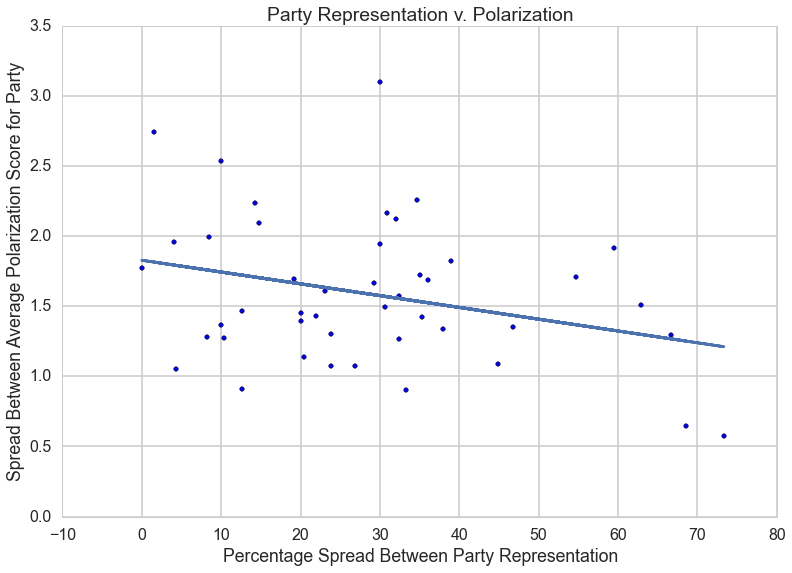

In [510]:
### OLS regression, shor scores versus party spreads
state_keys = ['al','ak','az','ar','ca','co','ct','de','fl','ga','hi','id','il','in','ia','la','me','md','ma','mi','mn','mo','mt','nv','nj','nm','ny','nc','nd','oh','ok','or','pa','ri','sc','sd','tn','tx','ut','vt','va','wa','wv','wi','wy']
categories4 = ["house spread", "shor score spread"]
hslist = propdf.drop(['ks','ky','ne','ms','nh'])
hslist2 = hslist['house spread'].tolist()
combined3 = [hslist2, shor_house_spread2]
spread_dict = dict(zip(categories4, combined3))
spreaddf = pd.DataFrame(spread_dict, index = state_keys)

### add constant
hslist2 = sm.add_constant(hslist2) 
hslist2

### OLS regression
olsest = sm.OLS(spreaddf2['shor score spread'], hslist2)
olsest = olsest.fit()
print olsest.summary()    
print olsest.params

### line of best fit
predict_y = 1.8271 + -0.0084 * spreaddf['house spread']

### scatter plot
plt.scatter(spreaddf['house spread'], spreaddf['shor score spread'])
plt.xlabel('Percentage Spread Between Party Representation')
plt.ylabel('Spread Between Average Polarization Score for Party')
plt.title('Party Representation v. Polarization')
pylab.plot(spreaddf['house spread'], predict_y)

### MY RESULTS ARE SIGNIFICANT!!!

In [710]:
### below reformats data into integers, only run once since columns are now altered

# nolow = submaster['novoteslower'].tolist()

# new_nolow = []
# for i in nolow:
#     if type(i) == list:
#         if len(i) > 0:
#             new_nolow.append(i[0])
#         else:
#             new_nolow.append(0)
#     else:
#         new_nolow.append(i)
        
# submaster['no votes lower new'] = new_nolow

# yeslow = submaster['yesvoteslower'].tolist()

# new_yeslow = []
# for i in yeslow:
#     if type(i) == list:
#         if len(i) > 0:
#             new_yeslow.append(i[0])
#         else:
#             new_yeslow.append(0)
#     else:
#         new_yeslow.append(i)

# submaster['yes votes lower new'] = new_yeslow

### calculates values for totals and percents, appends
submaster['total votes upper'] = submaster['novotesupper'] + submaster['yesvotesupper']
submaster['total votes lower'] = submaster['no votes lower new'] + submaster['yes votes lower new']
submaster['percent yes house'] = (submaster['yes votes lower new']/submaster['total votes lower'])*100
submaster['percent no house'] = (submaster['no votes lower new']/submaster['total votes lower'])*100
submaster['percent diff'] = abs(submaster['percent yes house'] - submaster['percent no house'])


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.245
Model:                            OLS   Adj. R-squared:                 -0.133
Method:                 Least Squares   F-statistic:                    0.6483
Date:                Sat, 16 Apr 2016   Prob (F-statistic):              0.505
Time:                        13:46:07   Log-Likelihood:                -13.587
No. Observations:                   4   AIC:                             31.17
Df Residuals:                       2   BIC:                             29.95
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         85.5048     11.579      7.384      0.0

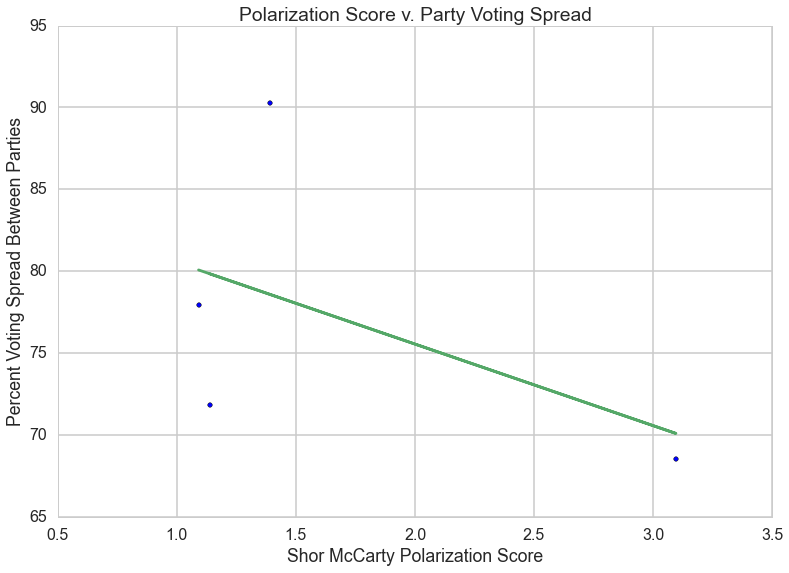

In [713]:
### UNADJUSTED, don't use

WI_MASTER = submaster.loc[submaster['state'] == 'wi']
wipd = WI_MASTER['percent diff'].mean()

LA_MASTER = submaster.loc[submaster['state'] == 'la']
lapd = LA_MASTER['percent diff'].mean()

CA_MASTER = submaster.loc[submaster['state'] == 'ca']
capd = CA_MASTER['percent diff'].mean()

SD_MASTER = submaster.loc[submaster['state'] == 'sd']
sdpd = SD_MASTER['percent diff'].mean()

pdiffs = [wipd, lapd, capd, sdpd]
shors = [1.139, 1.391, 3.096, 1.091]
plt.scatter(shors, pdiffs)

shors = sm.add_constant(shors)

ols2 = sm.OLS(pdiffs, shors)
ols2 = ols2.fit()
print ols2.summary()
print ols2.params

predict_y = 85.5048 + -4.9821 * shors

plt.xlabel('Shor McCarty Polarization Score')
plt.ylabel('Percent Voting Spread Between Parties')
plt.title('Polarization Score v. Party Voting Spread')
pylab.plot(shors, predict_y)

/Users/halleorr/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/halleorr/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/halleorr/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the the caveats in the documentation: http://pa

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.109
Model:                            OLS   Adj. R-squared:                 -0.337
Method:                 Least Squares   F-statistic:                    0.2439
Date:                Sat, 16 Apr 2016   Prob (F-statistic):              0.670
Time:                        16:30:49   Log-Likelihood:                -4.6803
No. Observations:                   4   AIC:                             13.36
Df Residuals:                       2   BIC:                             12.13
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const          2.6312      2.005      1.313      0.3

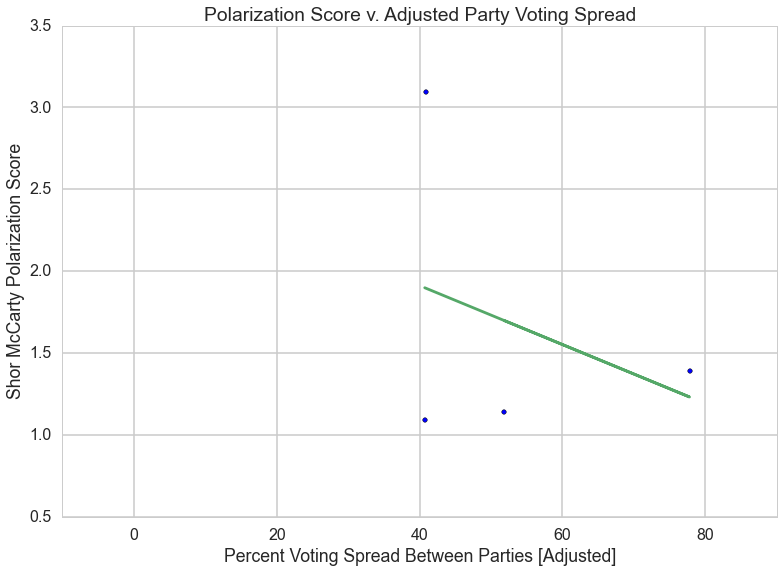

In [734]:
### ADJUSTED OLS REGRESSION, USE

wirepres = 20.408 ### percent spread between parties, taken from above
WI_MASTER['percent diff adjusted'] = abs(WI_MASTER['percent diff']-wirepres)
meanWI_MASTER = WI_MASTER['percent diff adjusted'].mean()

larepres = 12.621
LA_MASTER['percent diff adjusted'] = abs(LA_MASTER['percent diff']-larepres)
meanLA_MASTER = LA_MASTER['percent diff adjusted'].mean()

sdrepres = 44.927
SD_MASTER['percent diff adjusted'] = abs(SD_MASTER['percent diff']-sdrepres)
meanSD_MASTER = SD_MASTER['percent diff adjusted'].mean()

carepres = 30
CA_MASTER['percent diff adjusted'] = abs(CA_MASTER['percent diff']-carepres)
meanCA_MASTER = CA_MASTER['percent diff adjusted'].mean()

meanspd = [meanWI_MASTER, meanLA_MASTER, meanCA_MASTER, meanSD_MASTER]
shors = [1.139, 1.391, 3.096, 1.091]

plt.scatter(meanspd, shors)

meanspd = sm.add_constant(meanspd)

ols3 = sm.OLS(shors, meanspd)
ols3 = ols3.fit()
print ols3.summary()
print ols3.params

predict_y = 2.6312 - 0.0180* meanspd
pylab.plot(meanspd, predict_y)
plt.xlabel('Percent Voting Spread Between Parties [Adjusted]')
plt.ylabel('Shor McCarty Polarization Score')
plt.title('Polarization Score v. Adjusted Party Voting Spread')

In [725]:
# WI_social = MASTER.loc[MASTER['state'] == 'wi'].loc([MASTER['subject'] == 'Social Issues'])
# wisocial = WI_MASTER['percent diff adjusted'].mean()
# LA_social = MASTER.loc[MASTER['state'] == 'la'].loc([MASTER['subject'] == 'Social Issues'])
# lasocial = LA_MASTER['percent diff adjusted'].mean()
CA_social = CA_MASTER.loc[CA_MASTER['subject'] == 'Social Issues']
CA_social

# LA_MASTER = submaster.loc[submaster['state'] == 'la']
# casocial = CA_social['percent diff adjusted'].mean()
# SD_social = MASTER.loc[MASTER['state'] == 'sd'].loc([MASTER['subject'] == 'Social Issues'])
# sdsocial = SD_MASTER['percent diff adjusted'].mean()
# print meanspd
 
# socialmeans = [wisocial, lasocial, casocial, sdsocial]
# shors = [1.139, 1.391, 3.096, 1.091]
# print socialmeans
# plt.scatter(shors, socialmeans)

# shors = sm.add_constant(shors)

# ols3 = sm.OLS(meanspd, shors)
# ols3 = ols3.fit()
# print ols3.summary()
# print ols3.params

# plt.xlabel('Shor McCarty Polarization Score')
# plt.ylabel('Percent Voting Spread Between Parties [Adjusted]')
# plt.title('Polarization Score v. Adjusted Party Voting Spread')

,bill_id,novoteslower,novotesupper,state,subject,year,yesvoteslower,yesvotesupper,no votes lower new,yes votes lower new,total votes upper,total votes lower,percent yes house,percent no house,percent diff,percent diff adjusted
